# Heuristic Search 

In [1]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt

from map_utils import *
from search import *
from graphics_utils import *

In [2]:
def solve_and_plt(env: gym.Env, heuristic: callable, precision: str, plt_width: Tuple[int, int], plt_height: Tuple[int, int], dynamic: bool = False, suppress = False):
    state = env.reset()
    game_map = state["chars"]
    color_map = state["colors"]
    pixel_map = state["pixel"]

    start = get_player_location(game_map)
    target = get_target_location(game_map)

    if dynamic:
        dynamic_path_finding(game_map, color_map, start, target, env, heuristic, precision=precision, graphics=True, pixel_map=pixel_map, suppress=suppress)
    else:
        path = a_star(game_map, color_map, start, target, heuristic, precision=precision)
        actions = actions_from_path(start, path[1:])
        render_actions(actions, env, pixel_map, plt_width, plt_height)

## 1. The Fully Observable Environment

The idea was to approach the problem in an increasing level of difficolty fashion, first working on some simpler heuristics and cost functions, up to reaching a more sofisticated level of complexity. 

We started by comparing the Euclidean Distance and the Chebyshev Distance, in order to get a better grasp on what the problem could have been approached with, and after a short analysis, we've found out that the Chebyshev looked exactly like what we were searching for, since it guaranteed 8 normal vectors that precisely represented what the actions of the agent are supposed to be.

The agent successfully completed the task!


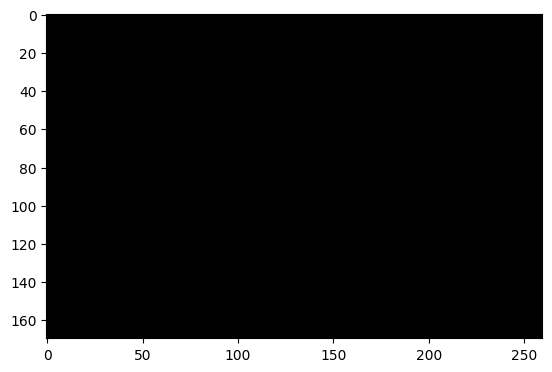

In [3]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=("chars", "pixel", "colors"), des_file = "dat/simple_maze.des")
solve_and_plt(env, heuristic=euclidean_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The agent successfully completed the task!


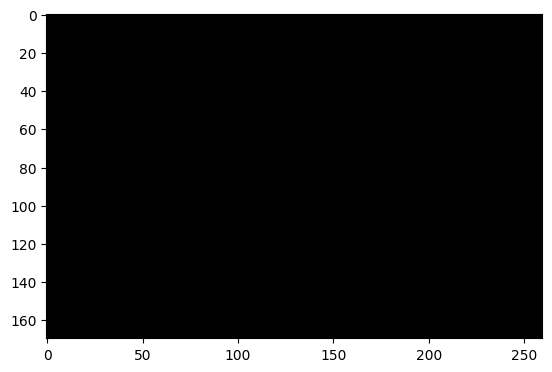

In [9]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=("chars", "pixel", "colors"), des_file = "dat/simple_maze.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

Initially, a simpler version of the problem was tackled. An A* algorithm was implemented that could find the optimal path in a map with trees.

The agent successfully completed the task!


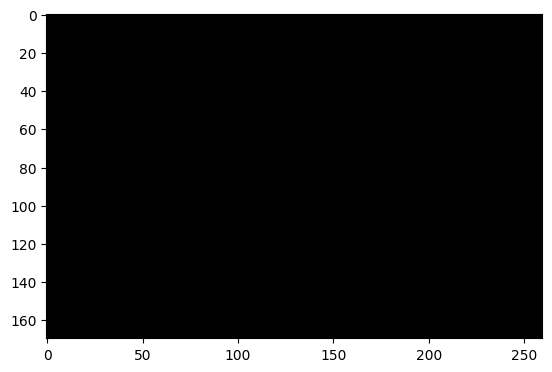

In [17]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/square_trees.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The algorithm also works on more intricate map configurations, that are not constrained to a square shape.

The agent successfully completed the task!


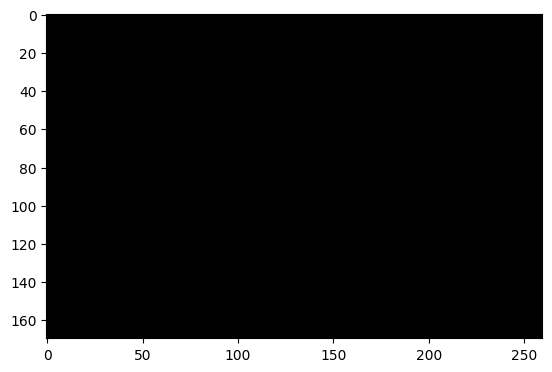

In [18]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/maze_trees.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The problem was made more complex with the introduction of clouds and a "grid bug," a relatively weak monster in Nethack. This creature, matching the player's speed, is unable to ever catch up with the agent, adding a strategic element to the scenario. 

To effectively face this issue, a dynamic A* algorithm was implemented. This  solution recalculates the path based on whether the monster is visible or not. In scenarios where the monster is visible, the agent incurs no penalties traversing through clouded areas. Instead, in instances where the monster remains hidden, traversing through clouded regions carries a risk, as these areas could be secret hiding places for the lurking monster.


The agent successfully completed the task!


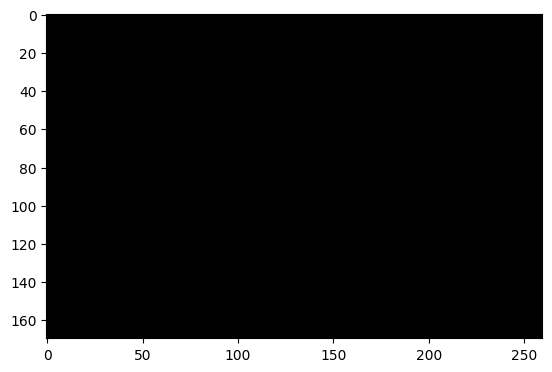

In [9]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/grid_bug.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The final stage of the fully observable problem involved addressing the comprehensive challenge at hand. A diverse array of monsters was integrated into the scenario. 

At first, we just applied the strategy used so far to get to the target, but we soon found out that we may have needed some more sofistication.

The agent died.


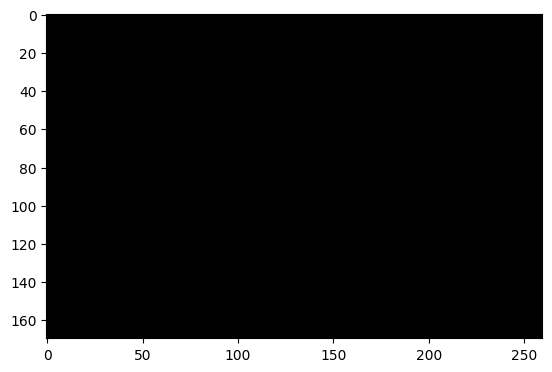

In [35]:
env = gym.make("MiniHack-HideNSeek-Mapped-v0", observation_keys=["chars", "pixel", "colors"])
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The idea behind the improved strategy roots in two simple concepts:
- when the agent has the chance to see the monster in the map, it should keep itself further from it
- when the agent does not have a chance to get to know where the monster may be hiding itself, the agent must stay further from clouds as much as it might, for this very reason

The agent died.


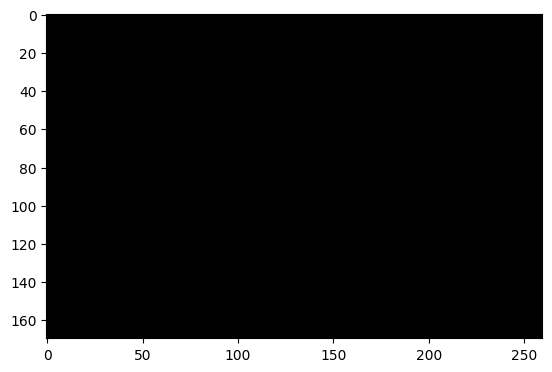

In [6]:
env = gym.make("MiniHack-HideNSeek-Mapped-v0", observation_keys=["chars", "pixel", "colors"])
solve_and_plt(env, heuristic=chebyshev_distance, precision="advanced", plt_width=(100, 270), plt_height=(500, 760), dynamic=True)

Let us give a brief discussion on the reasons behind the procedure rightfully working.

First, we will introduce the formulation of the Chebyshev Distance, i.e:
$$\text{let} \quad P = (p_1, p_2), \quad \text{and} \quad Q = (q_1, q_2)$$
$$d(P, Q) = \max(|p_1 - q_1|, |p_2 - q_2|)$$

The idea, as expressed before in more abstract terms, is to keep the agent as far as possible from the monster whenever it is visible from the map, this can be obtain by setting the $g$ function of the cost function $f$ in such a way that it weights cells closer to the monster more than cells further from it. 

This can be obtained by a simple manipulation of the function we used for the calculation of the distance between points in the plane, i.e. by simply calculating the reciprocal of the Chebyshev Distance between the position and the monsters itself. This gives us a function which is "rotation aware" (meaning it assigns the same value to positions falling in the radius of a circle (really squares to be precise)).

$$\text{let} \quad f(P, T) := g(P, M) + h(P, T),$$
$$\text{where} \quad \psi(P, M) := 
\begin{cases} 
    \frac{1}{d(P, M)}  & \text{if } d(P, M) > 0, \\
    maxcost & \text{if } d(P, M) = 0
\end{cases}, \quad \text{with} \quad maxcost = 10^{5}$$

$$\text{and} \quad h(P, T) := d(P, T)$$

Now we just set $g = \psi$ to obtain the desired outcome.

Notice that with $g$ we are comparing our neighbouring position $P$ with the monster position $M$, while with $h$ we are computing the exact distance (thanks to the Chebyshev Distance) between the neighbouring position $P$ and the target $T$.

Also, to be more precise, we implemented the above function with a slight variation, i.e. we split two cases from the one of the agent knowing the monster's position: one where $P$ is a cloud, and one where $P$ is not a cloud. As one might think, it can be advantageous to exploit clouds in order to run off the monster, but clouds have to be weighted in such a way that they must not incourage the agent to go against the monster in order to get in a cloud. To achieve this goal we could have implemented more sophisticated variations, but rather we chose a simple, yet effective approach (at least empirically), based on a very simple manipulation of the above function: 

$$\psi(P, M) := 
\begin{cases} 
    \frac{1}{d(P, M)}  & \text{if } d(P, M) > 0 \quad \text{and } P \notin Clouds, \\
    \left \lfloor \frac{1}{d(P, M)} \right \rfloor  & \text{if } d(P, M) > 0 \quad \text{and } P \in Clouds, \\
    maxcost & \text{if } d(P, M) = 0
\end{cases}, \quad \text{with} \quad maxcost = 10^{5}$$

The intuition behind this, is that the floor gives a very slight advantage to the cloud position in the cost function, precisely it will have an advantage $< 1$. This can be enough given that values won't be too big (by the size of the map), and hence we won't need large adjustments.

Now, let us make an observation about what we've seen so far: this only applies to cases where the agent does not know where the monster is located. In the other half of the cases, we need to make some more considerations: the agent must take care to get near clouds, since they really are ideal places for monsters to be hidden into. So, in order to "take care", we figured out a function to achieve this very reult.

$$\varphi := \sum_{C \in Clouds} \frac{1}{d(P, C)}$$

This function $\varphi$ can be interpreted as the "danger function", meaning that it gives a value to represent how much "dangerous" a position really is, basing the computation on the distance the position finds itself against each cloud in the map. To do so, we again exploit the reciprocal of the Chebyshev Distance, but this time we sum the amount of "danger" that each cloud project to the specific cell.

As before, we can use the original formulation, $f(P, Q) := g(P, Q) + h(P, Q)$, to express the cost function, but this time $g = \varphi$.

$$f(P, Q) := \sum_{C \in Clouds} \frac{1}{d(P, C)} + h(P, Q)$$

So, we can exploit the original formulation of $f$ to approach both the case where the monster is visible, and that of it being not in light, just by substituting $g$ with the function that suits the case.

Another important observation is that, in the case in which the agent does not know the monster's position, $g$ does not grow linearly as $h$ does (since it is of the form $\frac{1}{n}$ for the most part), hence this brings the conclusion that $h$ will have a bigger impact on most cases (i.e. each case where $h(P, T) > g(P, M)$, or to put it into words, every time the distance from the target is larger than the reciprocal of the distance from the monster, basically in most occasions). When we consider the case of $g = \varphi$, the reasoning actually changes a bit, since we are summing over the number of clouds in the map. In any case, this should not affect the algorithm in any particular way.

So, to conclude the discussion, we may interpret all this machinery as a filtering function: the first filter applies to positions that share the same value of $h$ (since that is the most weighted value), and amongst them the agent chooses the one that is less dangerous to be percolated.

A more involved analysis might be interesting to be carried on, but the choice to stop to this point is both of practical meaning and time constraints.

In any case, let us have a general discussion about the problem analysed. Since many of the monsters from the pool given by the MiniHack Environment, HideNSeek, are actually way too powerful to be played against with an empty inventory, we decided to only work on a small subset, one composed by only two monsters: Naga and the Giant. 

These two monsters appear to be pretty different from each other and this gives us a way to test the effectiveness of our approach on a level we'd like to.

#TODO expand discussion on monsters

The agent successfully completed the task!


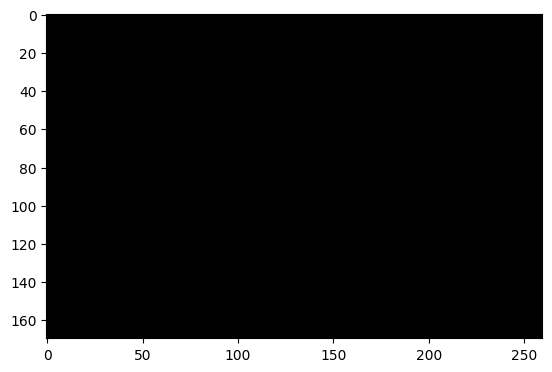

In [6]:
env = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_NH.des", observation_keys=["chars", "pixel", "colors"])
solve_and_plt(env, heuristic=chebyshev_distance, precision="advanced", plt_width=(100, 270), plt_height=(500, 760), dynamic=True)

In [3]:
win, loss, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dynamic_path_finding, des_file="dat/fully_observable_NH.des", evaluation_steps=500)

print(f"wins: {win}")
print(f"losses: {loss}")
print(f"beaten monsters: {monsters_win}")
print(f"monster that got us beaten: {monsters_loss}")

wins: 382
losses: 118
beaten monsters: ['N', 'H', 'N', 'N', 'N', 'H', 'N', 'H', 'H', 'N', 'N', 'N', None, 'N', 'H', None, 'N', 'N', 'N', None, 'N', 'H', 'N', 'H', 'H', None, 'N', None, 'H', None, 'N', 'N', 'H', 'H', None, 'N', 'N', 'H', None, 'N', None, 'N', 'N', 'H', None, 'H', 'N', 'H', 'N', 'H', None, 'N', None, None, 'H', 'H', 'H', 'N', 'N', 'N', 'N', 'H', 'H', 'N', 'H', 'N', 'N', 'H', None, 'N', 'H', 'N', 'N', None, 'N', None, 'N', None, 'N', 'N', 'N', 'H', None, 'H', 'N', 'H', 'N', None, 'H', 'N', 'H', None, 'H', None, 'H', None, None, None, None, 'N', 'N', None, 'N', 'H', None, 'H', 'N', 'H', 'H', None, 'H', 'N', 'N', 'N', 'H', 'N', 'H', None, 'H', 'N', None, 'N', None, 'N', 'N', 'H', None, 'N', 'H', None, 'N', 'N', 'H', 'N', 'H', None, None, 'H', 'H', 'H', 'H', 'H', 'H', 'N', None, 'H', 'H', 'H', 'H', None, 'H', None, 'H', 'N', 'H', None, None, None, 'N', 'H', 'H', None, 'H', 'N', 'N', 'H', 'H', 'N', 'N', 'H', 'H', 'H', 'H', 'N', 'H', None, None, None, 'N', None, None, 'N', 'H'

Let's have a look at the performance over Naga and the Giant alone

In [8]:
# NAGA
win, loss, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dynamic_path_finding, des_file="dat/fully_observable_N.des", evaluation_steps=500)

print(f"wins: {win}")
print(f"losses: {loss}")
print(f"beaten monsters: {monsters_win}")
print(f"monster that got us beaten: {monsters_loss}")

wins: 313
beaten monsters: ['N', 'N', None, 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', None, 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', None, None, 'N', None, 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', 'N', None, 'N', None, 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', 'N', None, None, 'N', None, None, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', 'N',

In [10]:
# GIANT
win, loss, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dynamic_path_finding, des_file="dat/fully_observable_H.des", evaluation_steps=500)

print(f"wins: {win}")
print(f"losses: {loss}")
print(f"beaten monsters: {monsters_win}")
print(f"monster that got us beaten: {monsters_loss}")

wins: 457
losses: 43
beaten monsters: ['H', 'H', 'H', None, None, None, 'H', 'H', 'H', None, 'H', 'H', None, 'H', 'H', 'H', 'H', 'H', None, 'H', 'H', None, 'H', None, None, 'H', None, 'H', 'H', 'H', 'H', 'H', 'H', None, None, None, 'H', 'H', 'H', 'H', 'H', None, 'H', 'H', None, 'H', None, 'H', 'H', None, 'H', 'H', None, None, 'H', None, 'H', 'H', 'H', None, 'H', None, 'H', 'H', 'H', None, 'H', 'H', 'H', 'H', 'H', None, None, 'H', None, 'H', None, None, None, 'H', 'H', None, None, 'H', None, 'H', None, 'H', 'H', 'H', None, 'H', None, None, None, None, None, 'H', 'H', 'H', None, 'H', None, 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', None, 'H', 'H', None, None, 'H', 'H', 'H', None, 'H', 'H', 'H', 'H', None, None, None, 'H', 'H', None, None, 'H', None, 'H', None, None, None, 'H', 'H', None, None, 'H', None, 'H', 'H', 'H', None, 'H', 'H', 'H', None, None, 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', None, None, None, 'H', 'H', None, 'H', 'H', 'H', None, None, None, None, 'H', 'H', None, 'H', 'H', 'H

And also let's have a look at how the algoritmh performs on the entire pool (all the monsters from HideNSeek)

In [11]:
win, loss, monsters_win, monsters_loss = evaluate_performance("MiniHack-HideNSeek-Mapped-v0", dynamic_path_finding, evaluation_steps=500)

print(f"wins: {win}")
print(f"losses: {loss}")
print(f"beaten monsters: {monsters_win}")
print(f"monster that got us beaten: {monsters_loss}")

wins: 382
losses: 118
beaten monsters: ['L', 'T', None, None, 'N', 'O', None, 'O', 'D', None, None, 'L', None, 'H', 'L', 'O', 'H', 'T', None, 'O', 'O', None, 'N', None, None, 'N', None, 'T', 'O', None, 'O', 'D', 'N', 'L', 'O', 'N', 'N', None, 'L', 'N', 'O', None, None, 'H', None, 'O', 'D', 'T', 'N', 'L', 'T', None, 'L', 'O', None, 'N', 'D', None, 'L', None, 'O', 'N', None, 'N', 'D', 'D', 'D', 'D', None, 'L', 'H', 'N', None, 'D', 'L', 'H', 'H', None, 'T', 'O', 'D', 'T', 'O', None, 'D', 'T', None, 'H', 'N', 'O', 'T', 'O', 'T', None, None, 'N', 'O', 'H', 'O', 'O', None, 'T', 'T', 'L', None, 'O', 'T', None, None, 'O', 'H', None, 'H', 'N', 'D', None, 'T', 'L', 'D', 'T', None, None, 'T', 'T', 'T', 'N', 'L', 'O', 'H', 'N', 'N', None, None, None, 'L', 'O', 'O', None, 'L', None, None, 'N', 'H', 'D', None, 'O', 'D', None, 'L', 'T', 'H', 'H', None, 'T', 'O', 'H', 'O', None, 'H', None, 'O', 'N', 'D', None, None, None, 'H', 'H', 'D', None, 'D', 'N', 'D', 'H', None, 'D', 'H', 'T', 'D', 'D', 'T', 'D'

#TODO statistics about monsters in the pool versions

In [13]:
ml = [x for x in monsters_loss if x != None]
np.unique(ml, return_counts=True)

In [3]:
from minihack import LevelGenerator

# Define the maze as a string
maze = """
...........
...........
...........
...........
...........
...........
...........
...........
...........
"""
# Set a start and goal positions
lvl_gen = LevelGenerator(map=maze,flags=('hardfloor','premapped'))
lvl_gen.set_start_pos((0,0))
lvl_gen.add_goal_pos((10,8))
# Add a Minotaur at fixed position
lvl_gen.add_monster(name="giant", place=(5,4))
lvl_gen.add_terrain((6,4),'C')
lvl_gen.add_terrain((1,0),'C')
lvl_gen.add_terrain((2,0),'T')
lvl_gen.add_terrain((4,0),'T')
lvl_gen.add_terrain((5,0),'T')
lvl_gen.add_terrain((7,0),'T')
lvl_gen.add_terrain((4,1),'C')
lvl_gen.add_terrain((6,1),'C')
lvl_gen.add_terrain((8,1),'C')
lvl_gen.add_terrain((0,2),'T')
lvl_gen.add_terrain((10,2),'C')
lvl_gen.add_terrain((0,3),'T')
lvl_gen.add_terrain((10,3),'C')
lvl_gen.add_terrain((1,3),'C')
lvl_gen.add_terrain((0,4),'T')
lvl_gen.add_terrain((8,4),'C')
lvl_gen.add_terrain((9,4),'C')
lvl_gen.add_terrain((1,4),'C')
lvl_gen.add_terrain((0,5),'C')
lvl_gen.add_terrain((1,5),'C')
lvl_gen.add_terrain((4,5),'C')
lvl_gen.add_terrain((9,5),'C')
lvl_gen.add_terrain((1,6),'T')
lvl_gen.add_terrain((5,6),'T')
lvl_gen.add_terrain((6,6),'C')
lvl_gen.add_terrain((10,6),'C')   
lvl_gen.add_terrain((4,7),'C')
lvl_gen.add_terrain((5,7),'C')
lvl_gen.add_terrain((6,7),'C')
lvl_gen.add_terrain((8,7),'C')   
lvl_gen.add_terrain((9,7),'T')    
lvl_gen.add_terrain((4,8),'T')
lvl_gen.add_terrain((1,8),'C')
lvl_gen.add_terrain((6,8),'C')
lvl_gen.add_terrain((7,8),'T')   
lvl_gen.add_terrain((8,8),'T')

The agent died.


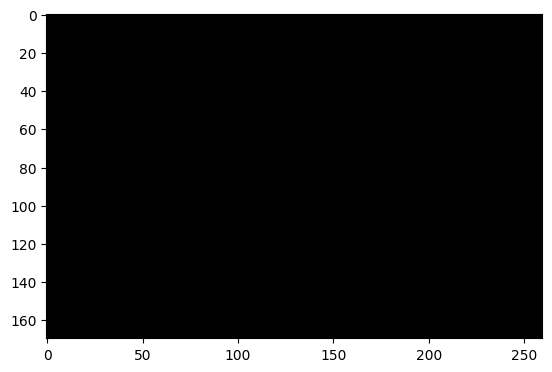

In [4]:
env = gym.make("MiniHack-Navigation-Custom-v0",des_file= lvl_gen.get_des(), observation_keys=('chars','colors','pixel'))
solve_and_plt(env, heuristic=chebyshev_distance, precision="advanced", plt_width=(100, 270), plt_height=(500, 760), dynamic=True)